**At a high level, you will submit 2 things in Part 2:**<br>
1. For a set of test customers in the file “test_user_info.csv”, you will calculate prices for each item for each customer so as to maximize expected revenue if you were a monopolist (i.e., as in HW3)<br>
a) You will submit a CSV. The CSV should have four columns: (1) user_index, (2) price_item_0, (3) price_item_1, and (4) expected_revenue.<br>
b) The file should be named `part2_static_prices_submission.csv`<br>
2. Your updated agent code from Part 1, but now incorporating demand estimation and optimal pricing for 2 items.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_pricing_decisions = pd.read_csv('train_prices_decisions.csv')
test_user_info = pd.read_csv('test_user_info.csv')

In [3]:
train_pricing_decisions.head()

,user_index,Covariate1,Covariate2,Covariate3,price_item_0,price_item_1,item_bought
0,0,4.319065,4.917636,6.054873,1.659785,3.598304,0
1,1,6.375840,7.228608,1.324521,13.120469,2.578281,1
2,2,1.524010,0.393772,4.873626,27.145855,4.538328,-1
3,3,1.243759,1.651083,2.268083,5.275166,14.818790,0
4,4,2.510326,8.265984,4.602699,12.681638,6.809336,0


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [5]:
def calc_confusion_matrix(pred_label, test_label):
    true_label = test_label
    predicted_label = pred_label
    print("Confusion Matrix :")
    print(confusion_matrix(true_label, predicted_label))
    print("Classification Report :")
    print(classification_report(true_label, predicted_label, digits=4))
    print('Weighted FScore: \n ', precision_recall_fscore_support(true_label, predicted_label, average='weighted'))

In [6]:
def fit_logistic_regression_demand_with_covariates(df):
    # training
    model = LogisticRegression(random_state=1,solver='liblinear')
    model.fit(df[['Covariate1','Covariate2','Covariate3','price_item_0','price_item_1']].values, df['item_bought'].values)
    return model

In [7]:
def get_prediction_logistic(fitted_model, price, covariates):
    x = np.hstack((covariates, price))
    return fitted_model.predict_proba(x)

In [8]:
# LR Model
lr_model = fit_logistic_regression_demand_with_covariates(train_pricing_decisions)

In [9]:
# Confusion Matrix of the Training Set
price = train_pricing_decisions[['price_item_0','price_item_1']].values
covariates = train_pricing_decisions[['Covariate1','Covariate2','Covariate3']].values
train_pred = get_prediction_logistic(lr_model, price, covariates)
train_pred = np.argmax(train_pred, axis=1)
calc_confusion_matrix(train_pred, train_pricing_decisions['item_bought'].values+1)

Confusion Matrix :
[[7817  794  750]
 [ 581 9240  975]
 [ 788  856 8199]]
Classification Report :
              precision    recall  f1-score   support

           0     0.8510    0.8351    0.8429      9361
           1     0.8485    0.8559    0.8522     10796
           2     0.8262    0.8330    0.8296      9843

    accuracy                         0.8419     30000
   macro avg     0.8419    0.8413    0.8416     30000
weighted avg     0.8419    0.8419    0.8419     30000

Weighted FScore: 
  (0.841941382665533, 0.8418666666666667, 0.8418702735316798, None)


In [34]:
# Revenue = price(A) * demand(A) + price(B) * demand(B)
def get_revenue_maximizing_price_and_revenue(price_options, demand_predictions):
    price = [0,0]
    revenue = 0
    tmp = 0
    for i in range(len(price_options)):
        tmp = price_options[i][0] * demand_predictions[i][1] + price_options[i][1] * demand_predictions[i][2]
        if tmp > revenue:
            price[0] = price_options[i][0]
            price[1] = price_options[i][1]
            revenue = tmp
    return price, revenue

In [27]:
# Demand curves of price_item_0 and price_item_1
price_all = train_pricing_decisions[['price_item_0','price_item_1']].values
covariates_all = train_pricing_decisions[['Covariate1','Covariate2','Covariate3']].values
train_pred_all = get_prediction_logistic(lr_model, price_all, covariates_all)

price_item_0 = train_pricing_decisions['price_item_0'].values
price_item_1 = train_pricing_decisions['price_item_1'].values
demand_item_0 = train_pred_all[:,1]
demand_item_1 = train_pred_all[:,2]

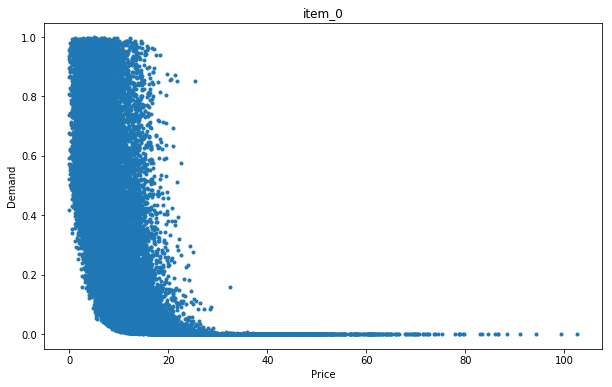

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(price_item_0, demand_item_0,'.')
plt.title('item_0')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.show()

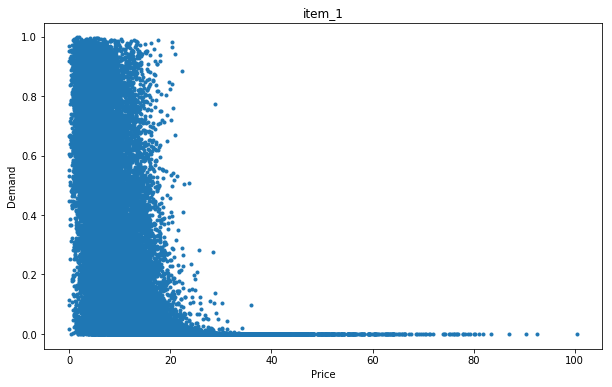

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(price_item_1, demand_item_1,'.')
plt.title('item_1')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.show()

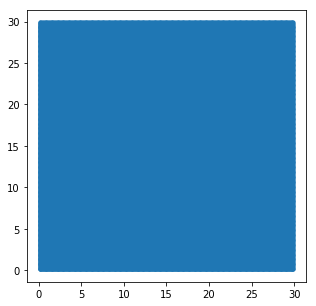

In [31]:
# Build a price set (sample prices from 0.1 to 30 in intervals of 0.1)
priceSet = []
x1 = np.arange(0.1, 30, 0.1)
x2 = np.arange(0.1, 30, 0.1)
for i in range(len(x1)):
    for j in range(len(x2)):
        priceSet.append([x1[i],x2[j]])
plt.figure(figsize=(5, 5))
plt.plot(np.array(priceSet)[:,0],np.array(priceSet)[:,1], ".")

In [35]:
covariates = np.array([[4.319065, 4.917636, 6.054873]])
covariates = np.tile(covariates, (len(priceSet),1))
demand_predictions = get_prediction_logistic(lr_model, priceSet, covariates)
opt_price, opt_revenue = get_revenue_maximizing_price_and_revenue(priceSet, demand_predictions)
print(opt_price)
print(opt_revenue)

[10.9, 8.7]
8.240699793654883


In [39]:
# test_user_info
user_index_list = test_user_info['user_index'].values
price_item_0_list = []
price_item_1_list = []
expected_revenue_list = []
for i in range(len(test_user_info)):
    covariates = test_user_info.iloc[i][['Covariate1','Covariate2','Covariate3']].values
    covariates = np.tile(covariates, (len(priceSet),1))
    demand_predictions = get_prediction_logistic(lr_model, priceSet, covariates)
    opt_price, opt_revenue = get_revenue_maximizing_price_and_revenue(priceSet, demand_predictions)
    price_item_0_list.append(opt_price[0])
    price_item_1_list.append(opt_price[1])
    expected_revenue_list.append(opt_revenue)

In [42]:
test_result_df = pd.DataFrame({'user_index':pd.Series(user_index_list),'price_item_0':pd.Series(price_item_0_list),
                  'price_item_1':pd.Series(price_item_1_list),'expected_revenue':pd.Series(expected_revenue_list)})
test_result_df.head()

,user_index,price_item_0,price_item_1,expected_revenue
0,30000,14.2,14.2,12.115873
1,30001,12.9,13.2,10.974568
2,30002,8.2,9.5,6.583577
3,30003,17.4,18.3,15.918515
4,30004,8.0,9.0,6.156433


In [43]:
test_result_df.to_csv( 'part2_static_prices_submission.csv',index=None)